<a href="https://colab.research.google.com/github/LeoisWTT/PHYS3151-Machine-Learning-in-Physics-2023/blob/main/feedforward-neural-network/MNielsen_network_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# A module to implement the gradient descent learning algorithm for a feedforward neural network.

import random
import numpy as np

class Network(object):
    
    # the list ''sizes'' contains the number of neurons in the respective layers of the network.
    # [2, 3, 1] input layer 2 neurons, hidden layer 3 neurons, output layer 1 neuron
    def __init__(self, sizes):

        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
       
    # return the output of the network if "a" is input.
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    # “training_data” is a list of tuples "(x,y)" representing the training inputs and the desired outputs.
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):

        training_data = list(training_data)
        n = len(training_data)
        
        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)
            
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {} : {} / {}".format(j,self.evaluate(test_data),n_test));
            else:
                print("Epoch {} complete".format(j))
                
    # update the network's weights and biases by applying gradient descent 
    # using backpropagation to a single mini batch.
    # The ''mini_batch'' is a list of tuples "(x,y)", and "eta" is the learning rate.
    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                       for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
        
    # return a tuple "(nabla_b, nabla_w)" representing the gradient for the cost function.
    # "nabla_b" and "nabla_w" are layer-by-layer lists of numpy arrays.
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) #* \
  #          sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # l=1 means the last layer of the neurons
        # l=2 means the second-last layer
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    # the neural network's output is assumed to be the index of 
    # whichever neuron in the final layer has the highest activation.
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)),y)
                       for (x,y) in test_data]
        return sum(int(x == y) for (x,y) in test_results)
    
    # vector of partial derivatives \partial C_X / \partial a for the output activations.
    def cost_derivative(self, output_activations, y):
        return (output_activations-y)
    
# Miscellaneous functions
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))
    
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [12]:
neural_network = Network([2,3,1])
# show the random biases
neural_network.biases

[array([[-1.2012548 ],
        [ 0.34268377],
        [-1.05331073]]),
 array([[0.05745517]])]

In [13]:
# show the random weights
neural_network.weights

[array([[-0.80252056, -0.25635687],
        [ 0.84055294,  0.05929157],
        [-1.12097732, -1.38434122]]),
 array([[0.1591467 , 0.73770062, 0.50911051]])]

In [14]:
!git clone https://github.com/LeoisWTT/PHYS3151-Machine-Learning-in-Physics-2023

Cloning into 'PHYS3151-Machine-Learning-in-Physics-2023'...
remote: Enumerating objects: 588, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 588 (delta 95), reused 114 (delta 62), pack-reused 417
Receiving objects: 100% (588/588), 30.43 MiB | 21.88 MiB/s, done.
Resolving deltas: 100% (312/312), done.


In [38]:
# A library to load the MNIST image data.
import pickle
import gzip
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Return the MNIST data as a tuple containing the training data, the validation data, and the test data.
# The "training_data" is returned as a tuple with two entries.

# The first entry contains the actual training images. This is a numpy ndarray with 50,000 entries. Each entry is, 
# in turn, a numpy ndarray with 784 values, representing the 28 * 28 = 784 pixels in a single MNIST image.

# The second entry in the "training_data" tuple is a numpy ndarray containing 50,000 entries. Those entries
# are just the digit values (0,1,...,9) for the corresponding images contained in the first entry of the tuple.

# The "validation_data" and "test_data" are similar, except each contains only 10,000 images.
def load_data():

        f = gzip.open('/content/PHYS3151-Machine-Learning-in-Physics-2023/feedforward-neural-network/mnist.pkl.gz','rb')
        training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
        f.close()
        return (training_data, validation_data, test_data)

# Return a tuple containing "(training_data, validation_data, test_data)".
# "training_data" is a list containing 50,000 2-tuples "(x,y)". 
# "x" is a 784-dimensional numpy.ndarray containing the input image.
# "y" is a 10-dimensional numpy.ndarray representing the unit vector 
# corresponding to the correct digit for "x".
# "validation_data" and "test_data" are lists containing 10,000 2-tuples "(x,y)". In each case,
# "x" is a 784-dimensional numpy.ndarray containing the input image, and
# "y" is the corresponding classification, i.e., the digit values (integers) corresponding to "x".
def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784,1)) for x in tr_d[0]]
    
    plt.imshow(training_inputs[4999].reshape((28,28)),cmap=cm.Greys_r)
    plt.show()
    
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784,1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784,1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

# Return a 10-dimensional unit vector with a 1.0 in the jth position and zeros elsewhere.
# This is used to convert a digit (0...9) into a corresponding desired output from the neural network.
def vectorized_result(j):
    e = np.zeros((10,1))
    e[j] = 1.0
    return e    

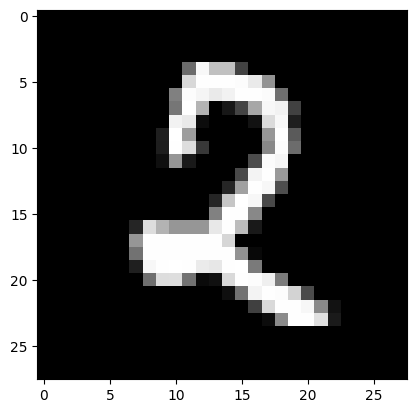

In [39]:
training_data, validation_data, test_data = load_data_wrapper()


In [40]:
net = Network([784,30,10])

In [41]:
net.SGD(training_data, 30, 10000, 3.0, test_data=test_data)     

Epoch 0 : 1912 / 10000
Epoch 1 : 3837 / 10000
Epoch 2 : 4894 / 10000
Epoch 3 : 5674 / 10000
Epoch 4 : 6189 / 10000
Epoch 5 : 6525 / 10000
Epoch 6 : 6813 / 10000
Epoch 7 : 7029 / 10000
Epoch 8 : 7196 / 10000
Epoch 9 : 7353 / 10000
Epoch 10 : 7482 / 10000
Epoch 11 : 7588 / 10000
Epoch 12 : 7710 / 10000
Epoch 13 : 7789 / 10000
Epoch 14 : 7851 / 10000
Epoch 15 : 7924 / 10000
Epoch 16 : 8001 / 10000
Epoch 17 : 8054 / 10000
Epoch 18 : 8105 / 10000
Epoch 19 : 8140 / 10000
Epoch 20 : 8181 / 10000
Epoch 21 : 8211 / 10000
Epoch 22 : 8243 / 10000
Epoch 23 : 8279 / 10000
Epoch 24 : 8312 / 10000
Epoch 25 : 8335 / 10000
Epoch 26 : 8367 / 10000
Epoch 27 : 8395 / 10000
Epoch 28 : 8415 / 10000
Epoch 29 : 8449 / 10000


In [ ]:
# An improved version of MNielsen_network, implementing the SGD learning algorithm for a feedforward neural network.
# Improvments include 
# 1. the cross-entropy cost function, 
# 2. regularization, 
# 3. better initialization of the weights.

import json
import random
import sys
import numpy as np

# define the quadratic and cross-entropy cost functions

class QuadraticCost(object):
    
    # return the cost associated with an output "a" and desired output "y".
    @staticmethod
    def fn(a, y):
        return 0.5*np.linalg.norm(a-y)**2
    
    # return the error delta from the output layer.
    @staticmethod
    def delta(z, a, y):
        return (a-y)*sigmoid_prime(z)
    
class CrossEntropyCost(object):
    
    # return the cost associated with an output "a" and desired output "y".
    # np.nan_to_num is used to ensure numerical stability, make sure 0*log(0) = 0.0
    @staticmethod
    def fn(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    
    # returm the error delta from the output layer.
    # parameter "z" is not used by the method. 
    @staticmethod
    def delta(z, a, y):
        return (a-y)
    
# Main Network class
class Network2(object):
    
    
    def __init__(self, sizes, cost=CrossEntropyCost):
        
        # the biases and weights for the network are initiated randomly, using "self.default_weight_initializer".
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost = cost
    
    def default_weight_initializer(self):
        
        # initialize each weight using a Gaussian distribution with mean 0 and standard deviation 1
        # over the square root of the number of weights connecting to the same neuron. 
        # initialize the biases using a Gaussian distribution with mean 0 and standard deviation 1.
    
        # for the input layers, there is no biases.
        self.biases = [np.random.randn(y,1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
            
        self.biases = [np.random.randn(y,1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
    
    # "evaluation_data", monitor the cost and accuracy on either the evaluation data or the training data.
    # returns a tuple containing four lists:
    # 1. the (per-epoch) costs on the evaluation data,
    # 2. the accuracies on the evaluation data,
    # 3. the costs on the training data,
    # 4. the accuracies on the training data.
    # If we train for 30 epochs, then the first element of the tuple will be a 
    # 30-element list containing the cost on the evaluation data at the end of each epoch.
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda=0.0,
            evaluation_data = None,
            monitor_evaluation_cost = False,
            monitor_evaluation_accuracy = False,
            monitor_training_cost = False,
            monitor_training_accuracy = False,
            early_stopping_n = 0):
        
        # early stopping functionality:
        best_accuracy=1
        
        training_data = list(training_data)
        n = len(training_data)
        
        if evaluation_data:
            evaluation_data = list(evaluation_data)
            n_data = len(evaluation_data)
            
        # early stopping functionality:
        best_accuracy=0
        no_accuracy_change=0
        
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta, lmbda, len(training_data))
                
            print("Epoch %s training complete" % j)
            
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(self.accuracy(evaluation_data), n_data))
            
            print()
            
            # Early stopping:
            if early_stopping_n > 0:
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    no_accuracy_change = 0
                    print("Early-stopping: Best so far{}".format(best_accuracy))
                else:
                    no_accuracy_change += 1
                    
                if (no_accuracy_change == early_stopping_n):
                    print("Early-stopping: No accuracy cahnge in last epochs: {}".format(early_stopping_n))
                    return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy
        
        return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy
    
    
    # "mini_batch" is a list of tuples "(x,y)"
    # "eta" is the learning rate
    # "lmbda" is the regularization parameter
    # "n" is the total size of the training set.
    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        # "eta*(lmbda/n)*w" comes from the regularization term.
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]
        
    # return a tuple "(nabla_b, nabla_w)" representing the gradient for the cost function.
    # "nabla_b" and "nabla_w" are layer-by-layer lists of numpy arrays.
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            
        # backpropagate
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    
    def accuracy(self, data, convert=False):
     
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y) for (x, y) in data]
        
        result_accuracy = sum(int(x==y) for (x,y) in results)
        return result_accuracy
    
    def total_cost(self, data, lmbda, convert=False):
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
            cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights)
        return cost
    
    # Save the neural network to the file "filename".
    def save(self, filename):
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()
        
        
# Loading a Network
def load(filename):
    
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

# Miscellaneous functions
def vectorized_result(j):
    
    e = np.zeros((10,1))
    e[j] = 1.0
    return e

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))
        
        

In [ ]:
# A library to load the MNIST image data.
import pickle
import gzip
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Return the MNIST data as a tuple containing the training data, the validation data, and the test data.
# The "training_data" is returned as a tuple with two entries.

# The first entry contains the actual training images. This is a numpy ndarray with 50,000 entries. Each entry is, 
# in turn, a numpy ndarray with 784 values, representing the 28 * 28 = 784 pixels in a single MNIST image.

# The second entry in the "training_data" tuple is a numpy ndarray containing 50,000 entries. Those entries
# are just the digit values (0,1,...,9) for the corresponding images contained in the first entry of the tuple.

# The "validation_data" and "test_data" are similar, except each contains only 10,000 images.
def load_data():

        f = gzip.open('/content/PHYS3151-Machine-Learning-in-Physics-2023/feedforward-neural-network/mnist.pkl.gz','rb')
        training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
        f.close()
        return (training_data, validation_data, test_data)

# Return a tuple containing "(training_data, validation_data, test_data)".
# "training_data" is a list containing 50,000 2-tuples "(x,y)". 
# "x" is a 784-dimensional numpy.ndarray containing the input image.
# "y" is a 10-dimensional numpy.ndarray representing the unit vector 
# corresponding to the correct digit for "x".
# "validation_data" and "test_data" are lists containing 10,000 2-tuples "(x,y)". In each case,
# "x" is a 784-dimensional numpy.ndarray containing the input image, and
# "y" is the corresponding classification, i.e., the digit values (integers) corresponding to "x".
def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784,1)) for x in tr_d[0]]
    
    plt.imshow(training_inputs[1].reshape((28,28)),cmap=cm.Greys_r)
    plt.show()
    
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784,1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784,1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

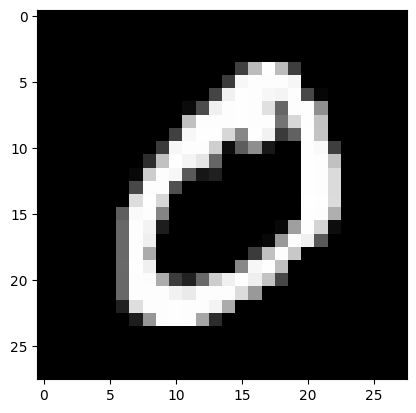

In [ ]:
training_data, validation_data, test_data = load_data_wrapper()

In [ ]:
net2 = Network2([784, 30, 10], cost=CrossEntropyCost)
net2.SGD(training_data, 30, 10, 0.5,lmbda = 5.0,evaluation_data=validation_data,monitor_evaluation_accuracy=True,
        monitor_evaluation_cost=True,monitor_training_accuracy=True,monitor_training_cost=True)

Epoch 0 training complete
Cost on training data: 3844.1101596254443
Accuracy on training data: 46989 / 50000
Cost on evaluation data: 3844.100621028285
Accuracy on evaluation data: 9428 / 10000

Epoch 1 training complete
Cost on training data: 4880.695170202227
Accuracy on training data: 47541 / 50000
Cost on evaluation data: 4880.702145281948
Accuracy on evaluation data: 9515 / 10000

Epoch 2 training complete
Cost on training data: 5411.010117729925
Accuracy on training data: 47812 / 50000
Cost on evaluation data: 5411.027788550623
Accuracy on evaluation data: 9528 / 10000

Epoch 3 training complete
Cost on training data: 5654.911300665737
Accuracy on training data: 47937 / 50000
Cost on evaluation data: 5654.9363028559565
Accuracy on evaluation data: 9546 / 10000

Epoch 4 training complete
Cost on training data: 5842.147690875823
Accuracy on training data: 48113 / 50000
Cost on evaluation data: 5842.179661866081
Accuracy on evaluation data: 9574 / 10000

Epoch 5 training complete
Co

([3844.100621028285,
  4880.702145281948,
  5411.027788550623,
  5654.9363028559565,
  5842.179661866081,
  6014.818915364679,
  6150.548112313024,
  6191.923165550737,
  6239.362249953372,
  6301.392972168657,
  6338.678544220402,
  6373.232752062508,
  6407.590935567854,
  6389.359891199289,
  6426.504183376902,
  6488.044942906086,
  6502.869872549435,
  6522.075359888333,
  6557.607994088356,
  6525.873122129182,
  6550.940060594596,
  6582.77906852298,
  6564.829048962007,
  6626.255971763323,
  6619.693864310016,
  6589.5762558127135,
  6638.627087318033,
  6632.830210377285,
  6661.366485846619,
  6663.0286352833455],
 [9428,
  9515,
  9528,
  9546,
  9574,
  9547,
  9575,
  9566,
  9592,
  9612,
  9628,
  9569,
  9600,
  9604,
  9588,
  9581,
  9615,
  9659,
  9638,
  9622,
  9609,
  9623,
  9624,
  9615,
  9638,
  9584,
  9652,
  9623,
  9620,
  9650],
 [3844.1101596254443,
  4880.695170202227,
  5411.010117729925,
  5654.911300665737,
  5842.147690875823,
  6014.782739047772,

In [ ]:
netQuadratic = Network2([784, 30, 10], cost=QuadraticCost)


In [ ]:
netQuadratic.SGD(training_data, 30, 10, 0.5,lmbda = 5.0,evaluation_data=validation_data,monitor_evaluation_accuracy=True,
        monitor_evaluation_cost=True,monitor_training_accuracy=True,monitor_training_cost=True)

Epoch 0 training complete
Cost on training data: 0.0
Accuracy on training data: 0 / 0
Cost on evaluation data: 0.0
Accuracy on evaluation data: 0 / 0

Epoch 1 training complete
Cost on training data: 0.0
Accuracy on training data: 0 / 0
Cost on evaluation data: 0.0
Accuracy on evaluation data: 0 / 0

Epoch 2 training complete
Cost on training data: 0.0
Accuracy on training data: 0 / 0
Cost on evaluation data: 0.0
Accuracy on evaluation data: 0 / 0

Epoch 3 training complete
Cost on training data: 0.0
Accuracy on training data: 0 / 0
Cost on evaluation data: 0.0
Accuracy on evaluation data: 0 / 0

Epoch 4 training complete
Cost on training data: 0.0
Accuracy on training data: 0 / 0
Cost on evaluation data: 0.0
Accuracy on evaluation data: 0 / 0

Epoch 5 training complete
Cost on training data: 0.0
Accuracy on training data: 0 / 0
Cost on evaluation data: 0.0
Accuracy on evaluation data: 0 / 0

Epoch 6 training complete
Cost on training data: 0.0
Accuracy on training data: 0 / 0
Cost on 

([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0])